# Анализ рынка заведений общественного питания Москвы

**Цель исследования**: произвести анализ текущего положения дела на рынке общепита Москвы для обоснования возможности открытия нового заведения.

**Ход исследования**

Входные данные находятся в файле `rest_data.csv`. О качестве данных ничего не известно, поэтому перед исследованием понадобится обзор данных. 

Необходимо проверить данные на ошибки и оценить их влияние на исследование. Затем, на этапе предобработки найти возможность исправить самые критичные ошибки данных. 

Таким образом, исследование пройдёт в четыре этапа:
 1. [Обзор данных](1)
 2. [Предобработка данных](2)
 3. [Исследовательский анализ данных](3):         
     - [Распределение заведений по типу объекта](4)
     - [Распределение заведений по характеристике "сетевой-несетевой"](5)
     - [Среднее количество посадочных мест по объектам](6)
     - [Улицы с самым большим количеством заведений](7)
     - [Улицы с одним заведением](8)
     - [Исследование сетевых заведений](9)
     - [Графическое изображение кластеров с заведениями на карте](10)


 4. [Вывод](11)

        

In [2]:
#Импорт используемых в работе библиотек

import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import plotly.express as px 
import folium 
import geopandas 
import geopy 
import csv 
pd.set_option('float_format', '{:f}'.format) 
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from matplotlib import rcParams
from plotly import graph_objects as go
from io import BytesIO
import requests
from fuzzywuzzy import fuzz
pd.set_option('display.max_colwidth', None)
from plotly.offline import iplot
from functools import partial
import time
import re
from ast import literal_eval
#pd.options.mode.chained_assignment = None

In [79]:
#Чтение файла с сохранением в датафрейм

if os.path.exists(r'C:\Users\abagapov\Downloads\rest_data.csv'):
    df = pd.read_csv(r'C:\Users\abagapov\Downloads\rest_data.csv')
else:
    df = pd.read_csv('/datasets/rest_data.csv')
    
spreadsheet_id = '1DUEaGG6svT6_EZIZsXz8gswBulxf0_QEqZz8h6dDhHE'
url = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
df_districts = pd.read_csv(url)

In [80]:
def first_view(df):
    '''
    Общее представление о датасете
    '''
    print('*'*50)
    print('Общая информация о датасете:')
    print('*'*50)
    df.info('*'*50) 
    print('*'*50)
    print('Пять случайных строк таблицы:')
    display(df.sample(5, random_state=42)) 
    print('*'*50)
    print('Статистические параметры таблицы:')
    display(df.describe())
    print('*'*50)
    print('Количество пустых значений:')
    display(pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')) 
    print('*'*50)
    print('Доля пропусков в столбцах:')
    display(pd.DataFrame(df.isna().mean()).style.background_gradient('coolwarm'))
    print('*'*50)
    print('Количество полных дубликатов:')
    print(df.duplicated().sum()) 
    print('*'*50)

In [81]:
# Функция для получения координат объекта

geolocator = Nominatim(user_agent="my_fancy_application")

direct = partial(geolocator.geocode, language="ru")
reverse = partial(geolocator.reverse, language="ru")


def get_lat_lng_district(address, street, direct, reverse):
    
    '''
    Функция для получения координат объекта
    '''
    
    time.sleep(1)
        
    try:
        house = re.search(', дом (\d+)', address).group(1)
        
    except Exception:
        house = None
        
    location = direct({'city' : 'Москва', 'street' : f"{street} {house}"})
    
    
    if location is None:
        return [None, None, None]
    lat = location.latitude
    lng = location.longitude
    
    time.sleep(1)
        
    try:
        district = reverse(f"{lat}, {lng}").raw['address']['suburb']
    except KeyError:
        district = None
    
    return lat, lng, district


## Обзор данных <a id='1'></a>

In [82]:
# Посмотрим информацию по первому датасету

first_view(df)

**************************************************
Общая информация о датасете:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
**************************************************
Пять случайных строк таблицы:


,id,object_name,chain,object_type,address,number
12062,182973,БУРГЕР КИНГ,да,кафе,"город Москва, Ярославское шоссе, дом 69",60
8819,156321,Кафе «Тетя Мотя»,нет,кафе,"город Москва, проезд Сокольнического Круга, дом 7",100
14197,206042,Чебуречная,нет,магазин (отдел кулинарии),"город Москва, Открытое шоссе, дом 9, строение 9",0
6081,156891,Чудо Пекарня Шаргунь,нет,закусочная,"город Москва, Севастопольский проспект, дом 15, корпус 3",0
2478,27730,Столовая «ГАЛА ПИЦЦА»,нет,столовая,"город Москва, Варшавское шоссе, дом 116",46


**************************************************
Статистические параметры таблицы:


,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


**************************************************
Количество пустых значений:


,0
id,0
object_name,0
chain,0
object_type,0
address,0
number,0


**************************************************
Доля пропусков в столбцах:


,0
id,0.000000
object_name,0.000000
chain,0.000000
object_type,0.000000
address,0.000000
number,0.000000


**************************************************
Количество полных дубликатов:
0
**************************************************


Можно сразу отметить, что отсутствуют явные дубликаты и пустые значения, названия столбцов в едином стиле, форматы данных соответствуют ожидаемым.

In [83]:
# Посмотрим на долю заведений без мест

checking_pivot = df.pivot_table(index='object_type', values='number', aggfunc='count')
checking_pivot['number_zoro'] = df.query('number == 0').pivot_table(index='object_type', values='number', aggfunc='count')
checking_pivot['ratio'] = checking_pivot['number_zoro'] / checking_pivot['number']
checking_pivot = checking_pivot.sort_values(by='ratio', ascending=False)
checking_pivot = checking_pivot.style.format({
    'ratio': '{:,.2%}'.format,
})
checking_pivot

,number,number_zoro,ratio
object_type,,,
магазин (отдел кулинарии),273,145,53.11%
закусочная,360,189,52.50%
предприятие быстрого обслуживания,1923,704,36.61%
кафетерий,398,113,28.39%
буфет,585,68,11.62%
кафе,6099,310,5.08%
бар,856,28,3.27%
ресторан,2285,45,1.97%
столовая,2587,19,0.73%


В принципе, данные по заведениям с отсутствующими местами посадки выглядят адекватными: отделы кулинарии, закусочные, фастфуды и кафетерии могут не иметь посадочных.

In [84]:
# Посмотрим информацию по второму датасету

first_view(df_districts)

**************************************************
Общая информация о датасете:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   streetname  4398 non-null   object
 1   areaid      4398 non-null   int64 
 2   okrug       4398 non-null   object
 3   area        4398 non-null   object
dtypes: int64(1), object(3)
memory usage: 137.6+ KB
**************************************************
Пять случайных строк таблицы:


,streetname,areaid,okrug,area
1720,Овражная улица,51,Зеленоград,Район Крюково
1108,1-я Боевская улица,26,ВАО,Район Сокольники
2821,Староспасская улица,88,СЗАО,Район Митино
3677,1-я Фрезерная улица,117,ЮВАО,Нижегородский район
1862,улица Нижняя Масловка,54,САО,Район Аэропорт


**************************************************
Статистические параметры таблицы:


,areaid
count,4398.000000
mean,59.213734
std,38.474637
min,12.000000
25%,20.000000
50%,51.000000
75%,93.000000
max,134.000000


**************************************************
Количество пустых значений:


,0
streetname,0
areaid,0
okrug,0
area,0


**************************************************
Доля пропусков в столбцах:


,0
streetname,0.000000
areaid,0.000000
okrug,0.000000
area,0.000000


**************************************************
Количество полных дубликатов:
8
**************************************************


Существуют 8 явных дубликатов, а также написанные транслитом названия столбца okrug.

In [85]:
# Посмотрим на количество уникальных значений столбца 'object_name'

df['object_name'].nunique()

10393

Слишком много уникальных значений, чтобы вручную выявить неявные дубликаты.

In [86]:
# Посмотрим на количество уникальных значений сетевых заведений столбца 'object_name'

df[df['chain'] == 'да']['object_name'].nunique()

724

In [87]:
# Посмотрим на неявные дубликаты среди сетевых ресторанов

df[df['chain'] == 'да']['object_name'].unique()

array(['ПИЦЦЕТОРИЯ', 'Брусника', 'Алло Пицца', 'Суши Wok', 'Тануки',
       "Домино'с Пицца", 'Готика', 'Му-Му', 'Хлеб насущный', 'TAJJ MAHAL',
       'ДАНКИН ДОНАТС', 'Вареничная №1', 'ШОКОЛАДНИЦА', 'Теремок',
       'Хинкальная', 'Шантимель', 'ТАНУКИ', 'Шоколадница', 'МУ-МУ',
       'Хинкальная City', 'КРУЖКА', 'СУШИ ВОК', 'ПРИМАВЕРА', 'Виктория',
       'Пиццерия «АКАДЕМИЯ»', 'Чебуречная СССР', 'МАКДОНАЛДС',
       'Grand Cru', 'Чайхона №1', 'Панчо Пицца', 'KFC', 'Сабвей',
       'ресторан «Якитория»', 'Советские времена', 'Кафе «Андерсон»',
       'Кафе «Subway»', 'Ресторан «Макдоналдс»', 'Суши Сет', 'Суши WoK',
       'Шоколад', 'Тирольские пироги', 'Гамбринус', 'Пицца Фабрика',
       'Subway', 'Кафе «Якитория»', 'Кафе «Тануки»', 'Сити Пицца',
       'Кружка', 'Кофе Хаус',
       'Кулинарная Лавка Братьев Караваевых Братья Караваевы', 'Суши Вок',
       'Прайм', 'Пицца Экспресс', 'Шоколадница Кофе Хаус', 'Николай',
       'Якитория', 'МАГНОЛИЯ', 'КОФЕ С СОБОЙ', 'Джаганнат', 'Волк

Выявлено обилие неявных дубликатов сетей Макдоналдс, Додо пицца, Старбакс и др. Избавимся от них на этапе предобработки.

In [88]:
# Посмотрим на уникальные значения столбца 'chain'

df['chain'].unique()

array(['нет', 'да'], dtype=object)

Дубликатов не обнаружено

In [89]:
# Посмотрим на уникальные значения столбца 'object_type'

df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Дубликатов не обнаружено

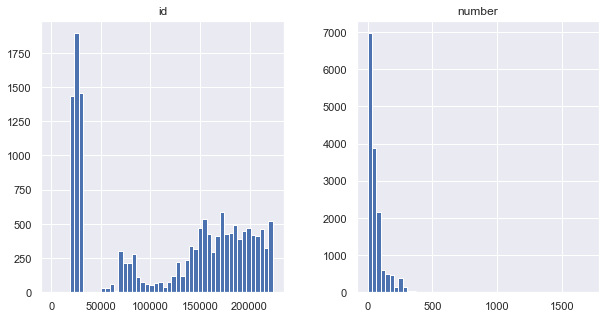

In [90]:
# Построим гистограмму числовых переменных

df.hist(figsize=[10,5], bins=50);

**Описание столбцов:**

df:

- id — идентификатор объекта;


- object_name — название объекта общественного питания;


- chain — сетевой ресторан;


- object_type — тип объекта общественного питания;


- address — адрес;


- number — количество посадочных мест.



df_districts:

- streetname — название улицы;


- areaid — идентификатор района;


- okrug — название округа;


- area — название района.

## Предоброботка данных <a id='2'></a>

In [91]:
# Во втором датафрейме поменяем названия столбцов

df_districts = df_districts.rename(columns={'okrug' : 'area', 'area' : 'district'})

In [92]:
# И удалим ненужные столбцы

df_districts = df_districts.drop('areaid', axis=1)

In [93]:
# Проверим изменения

df_districts

,streetname,area,district
0,Выставочный переулок,ЦАО,Пресненский район
1,улица Гашека,ЦАО,Пресненский район
2,Большая Никитская улица,ЦАО,Пресненский район
3,Глубокий переулок,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,ЦАО,Пресненский район
...,...,...,...
4393,Вознесенский проезд,ЦАО,Пресненский район
4394,Волков переулок,ЦАО,Пресненский район
4395,Поварская улица,ЦАО,Пресненский район
4396,Кудринская площадь,ЦАО,Пресненский район


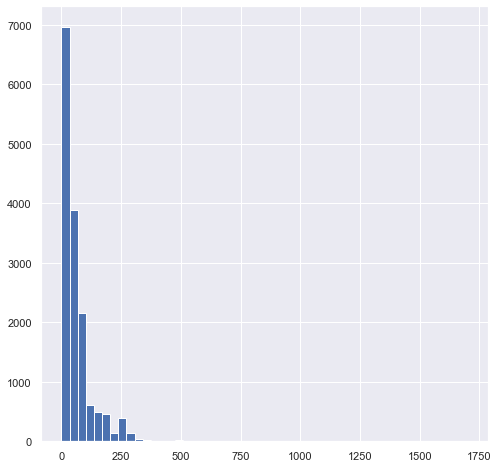

In [94]:
df['number'].hist(bins=50, figsize=[8,8]);

In [95]:
# Посмотрим на заведения с количеством мест более 500

df[df['number'] > 500]

,id,object_name,chain,object_type,address,number
120,26075,МАКДОНАЛДС,да,предприятие быстрого обслуживания,"город Москва, Большая Бронная улица, дом 29",580
2294,26988,Ресторан «Михаил Светлов»,нет,ресторан,"город Москва, Измайловское шоссе, дом 71, корпус 4Г-Д",542
2313,26560,Ресторан «АЛЬФА»,нет,ресторан,"город Москва, Измайловское шоссе, дом 71, корпус А",1040
2317,73306,Ресторан «БЕТА»,нет,ресторан,"город Москва, Измайловское шоссе, дом 71, корпус 2Б",660
3401,135197,ДУРДИНЪ,нет,ресторан,"город Москва, Мичуринский проспект, дом 8, строение 1",650
3686,27026,РУМ СЕРВИС,нет,ресторан,"город Москва, площадь Европы, дом 2",1200
4110,29320,Столовая,нет,столовая,"город Москва, Каширское шоссе, дом 31",680
4480,27024,РУМ СЕРВИС,нет,ресторан,"город Москва, Кутузовский проспект, дом 2/1, строение 1",1200
5327,23165,КАРДИНАЛ,нет,кафе,"город Москва, Хибинский проезд, дом 14, строение 1",533
5649,29232,СТОЛОВАЯ МОСКОВСКИЙ ГУМАНИТАРНЫЙ УНИВЕРСИТЕТ,нет,столовая,"город Москва, улица Юности, дом 5, строение 1",760


In [96]:
# Посмотрим на заведения с количеством мест более 200 и менее 500

df[df['number'].between(200, 500)]

,id,object_name,chain,object_type,address,number
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240
14,23670,Гимназия 1542,нет,столовая,"город Москва, улица Авиаторов, дом 16",270
15,23663,Школа 1011,нет,столовая,"город Москва, улица Авиаторов, дом 18",320
28,27439,ШКОЛА 1444,нет,столовая,"город Москва, Анадырский проезд, дом 55",240
31,29006,Гимназия № 1527,нет,столовая,"город Москва, проспект Андропова, дом 17, корпус 2",240
...,...,...,...,...,...,...
14776,209567,Шантри,нет,ресторан,"город Москва, Цветной бульвар, дом 30, строение 1",250
14806,217895,Ресторан - Глобус,нет,ресторан,"город Москва, Новорижское шоссе, 22-й километр, владение 1, строение 1",400
14832,222833,Sytiy Los,нет,ресторан,"город Москва, Ярцевская улица, дом 19",200
14971,208949,Столовая,нет,столовая,"город Москва, Отрадная улица, дом 2Б, строение 9",250


Количество посадочных мест более 500-600 кажется аномальным (это по логике, судя по violinplot можно считать выбросами значения более 350 посадочных). Возможно, это банкетные залы или просто ошибочные значения. В данных также есть столовые учебных заведений, которые нам совершенно не нужны. 

In [97]:
# Посмотрим на количество заведений без посадочных мест

df[df['number'] == 0]['number'].count()

1621

При анализе среднего и медианного количества мест данные заведения будут исключены.

Если совпадают и название, и адрес, и тип объекта, скорее всего, перед нами одно и то же заведение. Будем удалять.

In [98]:
# Найдем дубликаты по нескольким столбцам

df.duplicated(subset=['address','object_name', 'object_type']).sum()

171

In [99]:
# Удаление неявных дубликатов

df = df[df['id'].isin(df['id'][df.duplicated(subset=['address','object_name', 'object_type'])]) == False]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15195 entries, 0 to 15364
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15195 non-null  int64 
 1   object_name  15195 non-null  object
 2   chain        15195 non-null  object
 3   object_type  15195 non-null  object
 4   address      15195 non-null  object
 5   number       15195 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 831.0+ KB


In [100]:
# Создание среза с заведениями, в которых менее 600 мест

df.query('number < 600', inplace=True)

In [101]:
# Избавимся от неявных дубликатов в названиях, приведя к нижнему регистру

df['object_name'] = df['object_name'].str.lower()

In [102]:
# Посмотрим на количество уникальных значений

df['object_name'].nunique()

9909

In [103]:
# Создадим список дублирующихся сетевых заведений

restaurant_list = ['макдоналдс', 'бургер кинг', 'kfc', 'старбакс', 
                   'мята lounge', 'му-му', 'шоколадница', 'суши вок', 'subway', 
                   'магбургер', 'джон джоли', 'папа джонс', 'тарас бульба', 
                   'братья караваевы', 'тануки', 'вареничная №1', 'теремок', 
                   'якитория', 'волконский', 'прайм', 'азбука вкуса', 'ёрш', 
                   'кулинарное бюро', 'андерсон', 'крошка картошка', 'кофемания', 'coffeeshop']

In [104]:
# Заменим некоторые неявные дубликаты, используя расстояние Левенштейна

for a in df['object_name'].unique():
    for b in restaurant_list:
        s = fuzz.partial_ratio(a, b)
        if s > 80:
            df['object_name'].replace(a, b, inplace=True)

In [105]:
 # Посмотрим на количество уникальных значений

df['object_name'].nunique()

9693

Удалось убрать порядка полутора тысяч неявных дубликатов

In [106]:
# Уберем из датафрейма данные о столовыех в учебных заведениях

df = df[df['object_name'].str.contains('школ|сош|гимназия|институт|университет|колледжи|гбоу|школе|лицей') == False]

In [107]:
# Добавление столбца с улицей заведения

df['streetname'] = (
    df['address'].apply(lambda x: x.split(',')[1].strip() 
                        if x.split(',')[0] == 'город Москва' else x.split(',')[0])
)

In [108]:
df.head(1)

,id,object_name,chain,object_type,address,number,streetname
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова


In [109]:
# Удалим адреса, явно находящиеся за пределами старой Москвы

df = (
    df[df['address'].str.
contains('Зеленоград|Московский|Щербинка|Троицк|поселок|посёлок|деревня|поселение|километр|владение|Ленинские|Кузьминки') 
== False]
    )

In [333]:
# Поулучим координаты адресов и районы

df['coordinates'] = df.apply(lambda x: get_lat_lng_district(x['address'], x['streetname'], direct, reverse), axis=1)

In [111]:
# Создадим отдельно столбцы с координатами и районами

df['district'] = df['coordinates'].apply(lambda x: x[1])
df['coordinates'] = df['coordinates'].apply(lambda x: x[0])

In [113]:
# Посморим на информацию о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12828 entries, 0 to 15362
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           12828 non-null  int64 
 1   object_name  12828 non-null  object
 2   chain        12828 non-null  object
 3   object_type  12828 non-null  object
 4   address      12828 non-null  object
 5   number       12828 non-null  int64 
 6   streetname   12828 non-null  object
dtypes: int64(2), object(5)
memory usage: 801.8+ KB


## Исследовательский анализ данных <a id='3'></a>

In [144]:
pd.options.display.float_format = '{:,.0f}'.format 

### Распределение заведений по типу объекта <a id='4'></a>

In [145]:
# Соотношение типов заведений по количеству

type_pivot = df.pivot_table(index='object_type', values='id', aggfunc='count')
type_pivot.sort_values('id', ascending=False, inplace=True)
type_pivot

,id
object_type,
кафе,5540
ресторан,2142
предприятие быстрого обслуживания,1712
столовая,1347
бар,815
буфет,368
кафетерий,356
закусочная,302
магазин (отдел кулинарии),246


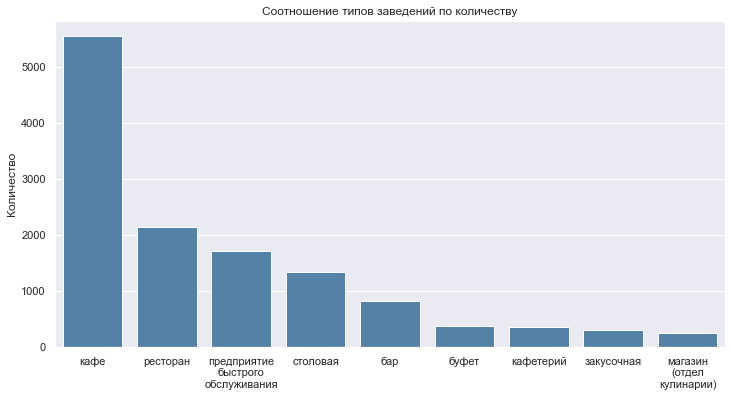

In [146]:
# Изобразим на графике

type_pivot.rename(index={'предприятие быстрого обслуживания':'предприятие\nбыстрого\nобслуживания', 
                         'магазин (отдел кулинарии)':'магазин\n(отдел\nкулинарии)'}, inplace=True)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=type_pivot.index, y=type_pivot['id'], ax=ax, color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Соотношение типов заведений по количеству')
ax.set_xlabel('')
ax.set_ylabel('Количество')
plt.show()

Самый распространенный тип заведения - кафе, далее идут ресторан и фастфуд.

### Распределение заведений по характеристике "сетевой-несетевой" <a id='5'></a>

In [147]:
# Соотношение видов заведение по количеству

chain_pivot = df.pivot_table(index='chain', values='id', aggfunc='count')
chain_pivot.sort_values('id', ascending=False, inplace=True)
chain_pivot

,id
chain,
нет,10075
да,2753


In [148]:
labels = ['Несетевые', 'Сетевые']
values = [chain_pivot['id'].loc[chain_pivot.index[0]],chain_pivot['id'].loc[chain_pivot.index[1]]]

common_props = dict(labels=labels,
                    values=values,)

trace1 = go.Pie(
    **common_props,
    textinfo='percent',
    textposition='outside')

trace2 = go.Pie(
    **common_props,
    textinfo='label',
    textposition='inside')

iplot([trace1, trace2], filename='basic_pie_chart')


Несетевых заведений почти в пять раз больше

In [149]:
# Посмотрим на соотношение типов заведений к их структуре

chain_type_pivot = df.pivot_table(index='object_type', columns='chain', values='id', aggfunc='count')
chain_type_pivot['ratio'] = (chain_type_pivot['да'] / (chain_type_pivot['нет'] + chain_type_pivot['да']))
chain_type_pivot.sort_values('ratio', ascending=False, inplace=True)
chain_type_pivot.rename(index={'предприятие быстрого обслуживания':'предприятие\nбыстрого\nобслуживания', 
                               'магазин (отдел кулинарии)':'магазин\n(отдел\nкулинарии)'}, inplace=True)
chain_type_pivot_rat = chain_type_pivot.style.format({
    'ratio': '{:,.2%}'.format,
})
chain_type_pivot_rat

chain,да,нет,ratio
object_type,,,
предприятие быстрого обслуживания,708,1004,41.36%
магазин (отдел кулинарии),76,170,30.89%
кафе,1315,4225,23.74%
ресторан,503,1639,23.48%
закусочная,53,249,17.55%
кафетерий,48,308,13.48%
бар,36,779,4.42%
буфет,11,357,2.99%
столовая,3,1344,0.22%


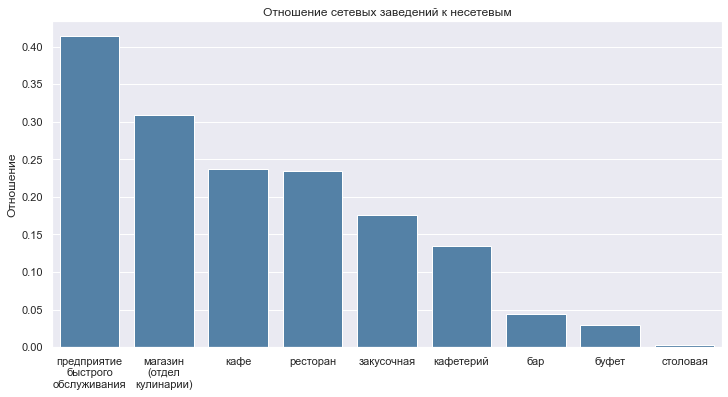

In [150]:
# Изобразим на графике

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=chain_type_pivot.index, y=chain_type_pivot.ratio, ax=ax, color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Отношение сетевых заведений к несетевым')
ax.set_xlabel('')
ax.set_ylabel('Отношение')
plt.show()

Для сетевого вида наиболее характерны предприятия быстрого обслуживания, дале - отделы кулинарии. Для типа "кафе", которое интересует нас, сети относительно слабо характерны - 23% являются сетевыми. 

### Среднее количество посадочных мест по объектам <a id='6'></a>

In [151]:
# Среднее количество посадочных мест

number_pivot = (
                df[df['number'] != 0].pivot_table(index='object_type', values='number', aggfunc='mean').
                sort_values('number', ascending=False)
               )

number_pivot.rename(index={'предприятие быстрого обслуживания':'предприятие\nбыстрого\nобслуживания', 
                           'магазин (отдел кулинарии)':'магазин\n(отдел\nкулинарии)'}, inplace=True)
number_pivot

,number
object_type,
столовая,103
ресторан,95
буфет,44
бар,44
кафе,43
предприятие\nбыстрого\nобслуживания,33
закусочная,17
кафетерий,13
магазин\n(отдел\nкулинарии),12


In [152]:
# Медианное количество посадочных мест

number_pivot_1 = (
                  df[df['number'] != 0].pivot_table(index='object_type', values='number', aggfunc='median').
                  sort_values('number', ascending=False)
                  )
number_pivot_1

,number
object_type,
ресторан,80
столовая,80
бар,36
кафе,35
буфет,30
предприятие быстрого обслуживания,20
закусочная,10
кафетерий,10
магазин (отдел кулинарии),8


Разница между интересующим нас типом, т.е. кафе - 9 мест, или 2-3 столика. Различие относительно.

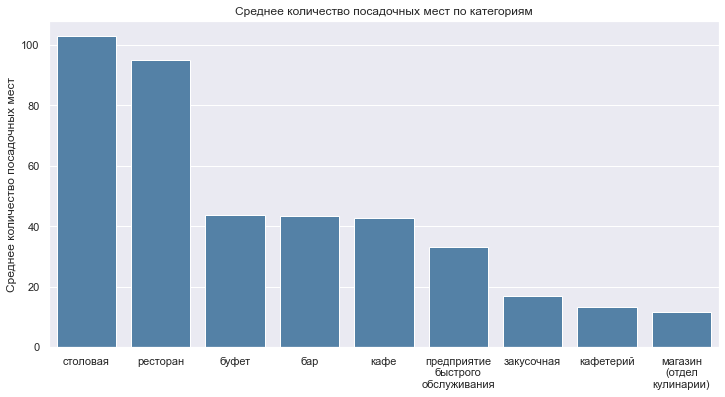

In [153]:
# Изобразим на графике

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=number_pivot.index, y=number_pivot.number, ax=ax, color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Среднее количество посадочных мест по категориям')
ax.set_xlabel('')
ax.set_ylabel('Среднее количество посадочных мест')
plt.show()

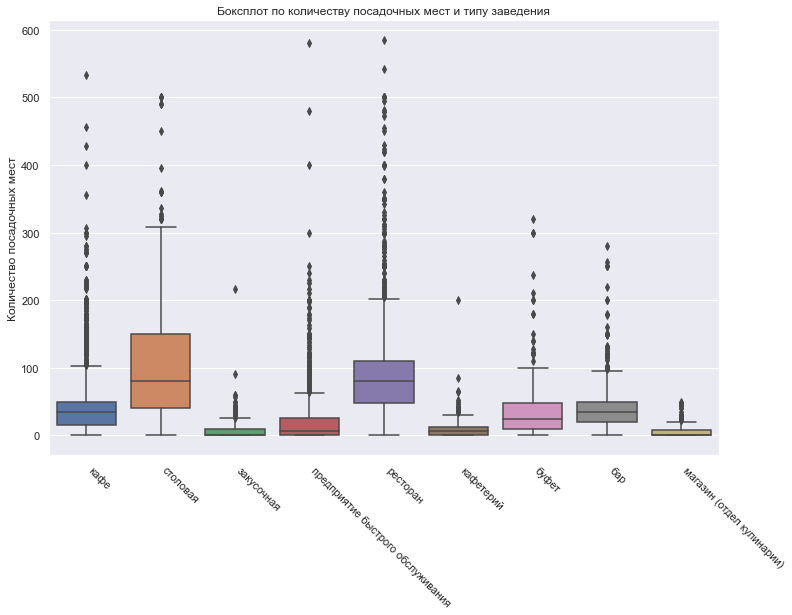

In [178]:
# Пострим боксплот для посадочных мест

sns.set(rc={'figure.figsize':(12, 8)})

ax = sns.boxplot(data=df, x='object_type', y='number');

ax.set_title('Боксплот по количеству посадочных мест и типу заведения')
ax.set_xlabel('')
ax.set_ylabel('Количество посадочных мест')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, horizontalalignment='left')
plt.show();

Самое большое среднее и медианное количество посадочных мест у столовых и ресторанов. Несмотря на то, что кафе по медианному количеству мест находится на пятом месте, по высоте выбросов они на третьем. 

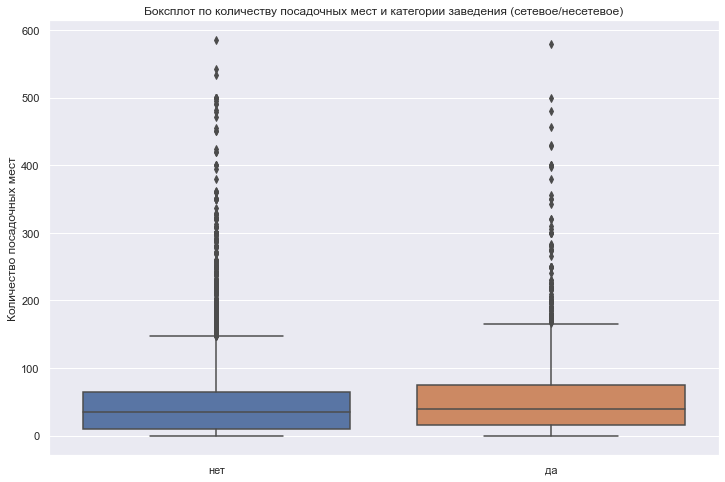

In [155]:
# Пострим боксплот для категорий заведений по сети

sns.set(rc={'figure.figsize':(12, 8)})

ax = sns.boxplot(data=df, x='chain', y='number');

ax.set_title('Боксплот по количеству посадочных мест и категории заведения (сетевое/несетевое)')
ax.set_xlabel('')
ax.set_ylabel('Количество посадочных мест')
plt.show();

Медианы посадочных мест у сетевых и несетевых практически не отличаются, но несетевые имеют больше выбросов по посадочным местам.

### Улицы с самым большим количеством заведений <a id='7'></a>

In [156]:
# Выведем самые ресторанные улицы города

streer_max_pivot = (df.pivot_table(index='streetname', values='id', aggfunc='count')
                  .sort_values('id', ascending=False).head(10)
                   )

streer_max_pivot

,id
streetname,
проспект Мира,193
Профсоюзная улица,173
Ленинградский проспект,168
Пресненская набережная,165
Варшавское шоссе,147
Ленинский проспект,135
проспект Вернадского,119
Кутузовский проспект,107
Ходынский бульвар,101


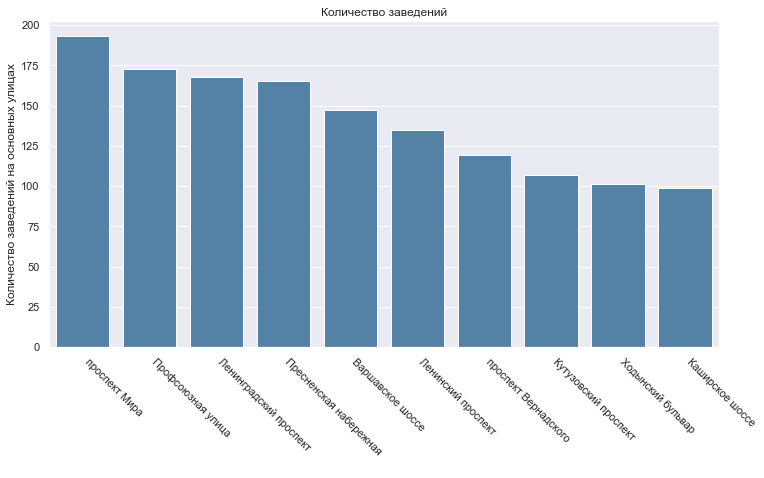

In [157]:
# Изобразим на графике

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=streer_max_pivot.index, y='id', data=streer_max_pivot, ax=ax, color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, horizontalalignment='left')
ax.set_title('Количество заведений')
ax.set_xlabel(' ')
ax.set_ylabel('Количество заведений на основных улицах')
plt.show()

Обилие мест питания можно объяснить не только большой проходимостью улиц, но и их огромной протяженностью.

In [158]:
streer_max_pivot = streer_max_pivot.merge(df_districts, how='left', on='streetname')

In [159]:
pd.DataFrame(streer_max_pivot.groupby('streetname')['area'].unique())

,area
streetname,
Варшавское шоссе,"[ЮАО, ЮЗАО]"
Каширское шоссе,[ЮАО]
Кутузовский проспект,[ЗАО]
Ленинградский проспект,[САО]
Ленинский проспект,"[ЗАО, ЮАО, ЮЗАО, ЦАО]"
Пресненская набережная,[ЦАО]
Профсоюзная улица,[ЮЗАО]
Ходынский бульвар,[САО]
проспект Вернадского,"[ЗАО, ЮЗАО]"


In [160]:
pd.DataFrame(streer_max_pivot.groupby('streetname')['district'].unique())

,district
streetname,
Варшавское шоссе,"[Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное, Донской район, Район Нагатино-Садовники, Нагорный район, Район Северное Бутово, Район Южное Бутово]"
Каширское шоссе,"[Район Москворечье-Сабурово, Район Нагатино-Садовники, Район Орехово-Борисово Южное, Район Орехово-Борисово Северное]"
Кутузовский проспект,"[Район Дорогомилово, Район Фили-Давыдково]"
Ленинградский проспект,"[Район Аэропорт, Район Беговой, Хорошевский район, Район Сокол]"
Ленинский проспект,"[Район Проспект Вернадского, Район Тропарево-Никулино, Донской район, Район Гагаринский, Ломоносовский район, Обручевский район, Район Теплый Стан, Район Якиманка]"
Пресненская набережная,[Пресненский район]
Профсоюзная улица,"[Академический район, Район Черемушки, Район Ясенево, Район Коньково, Обручевский район, Район Теплый Стан]"
Ходынский бульвар,[Хорошевский район]
проспект Вернадского,"[Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино, Район Гагаринский, Ломоносовский район]"


In [161]:
streer_max_pivot.pivot_table(index='streetname', values='district', aggfunc='count')

,district
streetname,
Варшавское шоссе,8
Каширское шоссе,4
Кутузовский проспект,2
Ленинградский проспект,4
Ленинский проспект,8
Пресненская набережная,1
Профсоюзная улица,6
Ходынский бульвар,1
проспект Вернадского,5


Только одна улица - Пресненская набережная, находится на территории одного района (возможно, он и являются самыми привлекательными). Кутузовский проспект расположен на территории двух районов, остальные проходят более, черем через четыре района. 

In [162]:
# Найдем топ-10 улиц, находящихся на территории одного района

streer_max_pivot_2 = (df.pivot_table(index='streetname', values='id', aggfunc='count')
                  .sort_values('id', ascending=False).merge(df_districts, how='left', on='streetname')
                   )

streets_for_deleting = (
streer_max_pivot_2.pivot_table(index='streetname', values='district', aggfunc='count')
.sort_values('district', ascending=False).query('district !=1')
)

streets_for_deleting_list = streets_for_deleting.index.tolist()

streer_max_pivot_2 = streer_max_pivot_2[~ streer_max_pivot_2['streetname'].isin(streets_for_deleting_list)].head(10)

streer_max_pivot_2

,streetname,id,area,district
17,Пресненская набережная,165,ЦАО,Пресненский район
41,Ходынский бульвар,101,САО,Хорошевский район
59,улица Новый Арбат,92,ЦАО,Район Арбат
63,улица Ленинская Слобода,88,ЮАО,Даниловский район
64,Пятницкая улица,80,ЦАО,Район Замоскворечье
67,улица Арбат,76,ЦАО,Район Арбат
80,улица Покровка,75,ЦАО,Басманный район
88,Тверская улица,68,ЦАО,Тверской район
89,Автозаводская улица,65,ЮАО,Даниловский район
97,Ярцевская улица,60,ЗАО,Район Кунцево


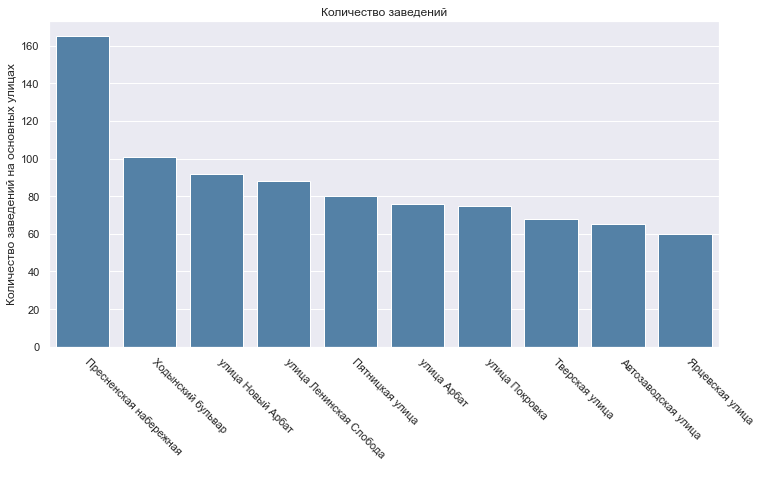

In [163]:
# Изобразим на графике

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='streetname', y='id', data=streer_max_pivot_2, ax=ax, color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, horizontalalignment='left')
ax.set_title('Количество заведений')
ax.set_xlabel(' ')
ax.set_ylabel('Количество заведений на основных улицах')
plt.show()

Из всех этих улиц  половина находится на территории Центрального округа. Также две улица находятся на территории одного и того же района - на Арбате, поэтому обратим на этот район особое внимание.

### Улицы с одним заведением <a id='8'></a>

In [164]:
# Выведем самые нересторанные улицы города


streer_min_pivot = (
                   df.pivot_table(index='streetname', values='id', aggfunc='count')
                   .sort_values('id', ascending=True)
                   )
                   
streer_min_pivot.query('id == 1').head(10)

,id
streetname,
Мерзляковский переулок,1
Заводской проезд,1
улица Крупской,1
Театральная аллея,1
Таёжная улица,1
Тарханская улица,1
Тарусская улица,1
Тессинский переулок,1
Зарайская улица,1


In [165]:
streer_min_pivot = streer_min_pivot.query('id == 1').merge(df_districts, how='left', on='streetname')
streer_min_pivot

,streetname,id,area,district
0,Мерзляковский переулок,1,ЦАО,Пресненский район
1,Мерзляковский переулок,1,ЦАО,Район Арбат
2,Заводской проезд,1,ВАО,Район Измайлово
3,улица Крупской,1,Зеленоград,Район Крюково
4,улица Крупской,1,ЮЗАО,Ломоносовский район
...,...,...,...,...
520,1-й Обыденский переулок,1,ЦАО,Район Хамовники
521,улица Говорова,1,ЗАО,Можайский Район
522,1-й Рижский переулок,1,СВАО,Алексеевский район
523,проезд Стройкомбината,1,ЗАО,Район Очаково-Матвеевское


In [166]:
streer_min_pivot.query('id == 1')['id'].count()

525

Существует 525 улиц с одним заведением. Не будет преувеличением сказать, что таковые есть почти что в каждом районе. Но посмотрим их количество в тех районах, где находятся улицы с самым большим количеством заведений.

In [167]:
# Количество улиц с одним заведением в районе Арбата

streer_min_pivot.query('district == "Район Арбат"')['id'].count()

18

In [168]:
# Количество улиц с одним заведением в Персенском районе

streer_min_pivot.query('district == "Пресненский район"')['id'].count()

17

Итак, самый перспективный округ - Центральный. В нем самые ресторанные районы Арбат и Пресненский. В каждом из них существует полтора десятка улиц, на которых находится всего по одному заведению. Если проанализировать проходимость этих улиц, ты сможем понять, нужно ли нам открываться на одной из них.

### Исследование сетевых заведений <a id='9'></a>

In [169]:
# Выведем десять самых крупных сетей питания

df_chain = (
    df.query('chain == "да"').pivot_table(index='object_name', values='id', aggfunc='count')
    .query('id > 1').sort_values(by='id', ascending=False)
)

df_chain.head(10)

,id
object_name,
шоколадница,179
kfc,167
макдоналдс,157
бургер кинг,144
теремок,101
домино'с пицца,89
крошка картошка,86
милти,68
суши wok,66


In [170]:
# Группировка

cut_labels = ['мелкие', 'средние', 'крупные']
cut_bins = [0, df_chain['id'].quantile(q=0.25), df_chain['id'].quantile(q=0.75), np.inf]

df_chain['chain_status'] = pd.cut(df_chain['id'],
                       bins=cut_bins,
                       labels=cut_labels)

df_chain

,id,chain_status
object_name,,
шоколадница,179,крупные
kfc,167,крупные
макдоналдс,157,крупные
бургер кинг,144,крупные
теремок,101,крупные
...,...,...
ирландский паб,2,мелкие
сбарро,2,мелкие
ми пьяче,2,мелкие


In [172]:
# Добавим также колонку со средним значением посадочных мест

df_chain['number_aver'] = (
                            df.query('chain == "да"').
                            pivot_table(index='object_name', values='number', aggfunc='mean').round()
                          )

df_chain

,id,chain_status,number_aver
object_name,,,
шоколадница,179,крупные,58
kfc,167,крупные,57
макдоналдс,157,крупные,91
бургер кинг,144,крупные,49
теремок,101,крупные,28
...,...,...,...
ирландский паб,2,мелкие,94
сбарро,2,мелкие,18
ми пьяче,2,мелкие,45


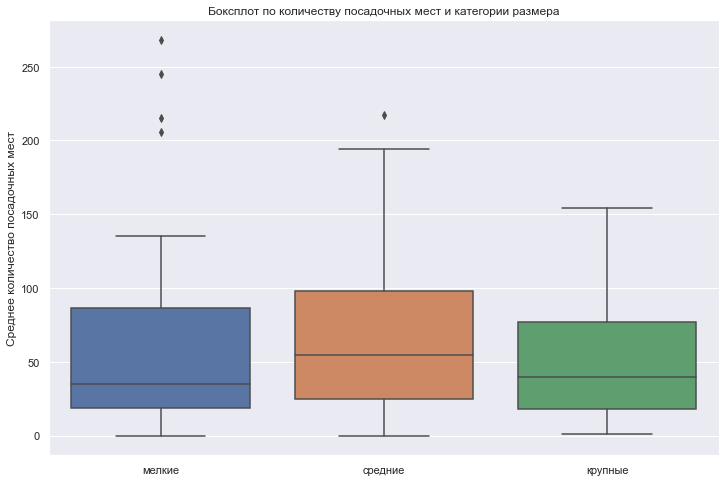

In [187]:
sns.set(rc={'figure.figsize':(12, 8)})

ax = sns.boxplot(data=df_chain, x='chain_status', y='number_aver');

ax.set_title('Боксплот по количеству посадочных мест и категории размера')
ax.set_xlabel('')
ax.set_ylabel('Среднее количество посадочных мест')
plt.show();

По графикам можно сказать, что подавляющее большинство мелких и крупных сетей по среднему количеству посадочных мест не превышает 150, средних - 200, выбросы с большими средними посадочными имеют лишь мелкие и средние сети.

In [175]:
# Создадим сводную таблицу по типу сети с суммой ресторанов, сетей, 
# медианным количеством заведений и количеством посадочных мест

df_chain.reset_index(inplace=True)
df_chain_aver = df_chain.pivot_table(index='chain_status', values='id', aggfunc='sum')
df_chain_aver.rename(columns={'id':'sum_of_rests'}, inplace=True)
df_chain_aver['sum_of_chains'] = df_chain.pivot_table(index='chain_status',
                                                      values='object_name', aggfunc='count')['object_name']
df_chain_aver['rest_median'] = df_chain.pivot_table(index='chain_status', values='id', aggfunc='median')['id']
df_chain_aver['number_median'] = df_chain.pivot_table(index='chain_status',
                                                      values='number_aver', aggfunc='median')['number_aver']
df_chain_aver

,sum_of_rests,sum_of_chains,rest_median,number_median
chain_status,,,,
мелкие,118,59,2,35
средние,381,86,4,54
крупные,2028,49,28,40


Медианные средние места находятся в диапазоне 35-55 посадочных мест в зависимости от размера сети.

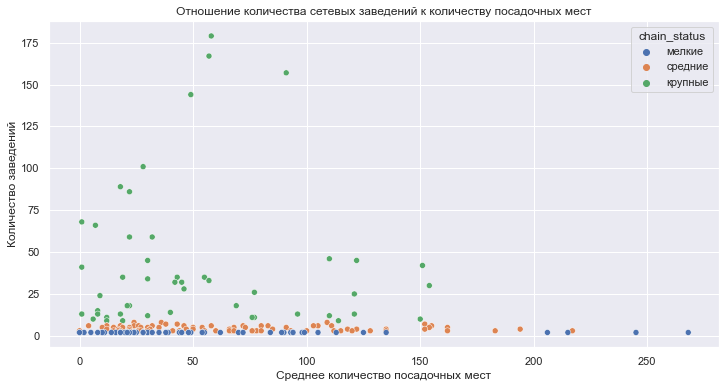

In [191]:
# Изобразим на графике

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('Среднее количество посадочных мест')
ax.set_title('Отношение количества сетевых заведений к количеству посадочных мест')
ax.set_ylabel('Количество заведений')
sns.scatterplot(data=df_chain, x='number_aver', y='id', hue='chain_status');

In [177]:
# Медианное количество заведений по сетям, которые работают с типом "кафе".

(
df.query('chain == "да" and object_type == "кафе"')
    .pivot_table(index='object_name', values='id', aggfunc='count').query('id > 1')
    .sort_values(by='id', ascending=False)['id'].median()
)

3.0

### Графическое изображение кластеров с заведениями на карте <a id='10'></a>

Судя по медианному значению, среднее кафе имеет 3 объекта.

In [5]:
# Посмотрим общее распределение кафе по карте

moscow_map = folium.Map(
                 location = [55.7522, 37.6156],    # широта и долгота Москвы
                 zoom_start = 10
                 )
                    

moscow_cluster = MarkerCluster().add_to(moscow_map)


#for i in df.query('coordinates == coordinates')['coordinates']:
#    (
#    folium.CircleMarker([i[0], i[1]], popup="{0}: {1}".format(df['id'], df['id']), color='black', radius=1, fill=True).
#    add_to(moscow_cluster)
#    )

#moscow_map

К сожалению, удалить все объекты за пределами старой Москвы не удалось, но на карте хорошо видно, что основная доля заведений сосредоточена в Центральном округе.

In [4]:
# Приближенно взглянем на Арбат


moscow_map = folium.Map(
                 location = [55.7498333, 37.59141675270675],    # широта и долгота Арбата
                 zoom_start = 15
                 )
                    


moscow_cluster = MarkerCluster().add_to(moscow_map)

#for i in df.query('coordinates == coordinates')['coordinates']:
#    (
#    folium.CircleMarker([i[0], i[1]], popup="{0}: {1}".format(df['id'], df['id']), color='black', radius=1, fill=True).
#    add_to(moscow_cluster)
#    )


#moscow_map

Как видно на карте, в районе Арбате самые ресторанные улицы - Арбат и, несколько меньше, Новый Арбат. При этом Арбат является улицей пешеходной. Возможно проанализировать проходимость улиц, пересекающих Арбат и Новый арбат, чтобы оценить возможность открыться на одной из них.

In [3]:
# Приближенно взглянем на Пресенский район

moscow_map = folium.Map(
                 location = [55.7489657, 37.5387342220545],    # широта и долгота Пресенского района
                 zoom_start = 14
                 )
                    

moscow_cluster = MarkerCluster().add_to(moscow_map)

#for i in df.query('coordinates == coordinates')['coordinates']:
#    (
#    folium.CircleMarker([i[0], i[1]], popup="{0}: {1}".format(df['id'], df['id']), color='black', radius=1, fill=True).
#    add_to(moscow_cluster)
#    )

#moscow_map

Пресенский район - район Москва-сити, скорее бизнес-район, чем туристический, поэтому, лучше сделать ставку на Арбат и похожие на него улицы.

## Вывод <a id='11'></a>

Для анализа был получен набор открытых данных о заведения общественного питания Москвы. Основная проблема обнаружилась в том, что в данных находится инфомация о заведениях не только из старой Москвы, но также и из Новой Москвы и, возможно, Московской области. Также были обнаружены неявные дубликаты, которые были определены как заведения, у которых одинаковы название, адрес и тип. 

В данных содержалась информация не только о частных заведениях, но и о столовых в учебных заведениях, которые также были удалены.

Удалению подлежали и заведения с количеством мест более 600, которые были определены как банкетные залы или ошибки.

Для ограничения данных до пределов старой Москвы была предпринята попытка объединить датафрейм со списком районов и округов старой Москвы, после чего данные без округа были удалены. К сожалению, процедура не убрала окончательно заведения за пределами нужной нам территории. 

Для дальнейшего исследования сетевых ресторанов они были приведены к единым стилям. Для графического отображения на карте с помощью сервиса геокодирования были получены координаты для каждого адреса, кроме некоторых нечитаемых.

Анализ данных выявил, что:


- Самым распространенным типом заведения является кафе;


- Несетевых заведений почти что в пять раз больше, чем сетевых;


- Самый большой процент сетевых заведений среди предприятий быстрого обслуживания;


- что подавляющее большинство мелких и крупных сетей по среднему количеству посадочных мест не превышает 150, средних - 200, выбросы с большими средними посадочными имеют лишь мелкие и средние сети;


- Самое большое среднее количество посадочных - у столовых, медианное - у ресторанов. Кафе имеет 35 посадочных мест по медиане;


- Среди сетевых кафе среднее количество заведений в сети - 3;


- Большинство улиц, на которых находится самое большое количество ресторанов, проходят через несколько районов и/или округов, поэтому это число является показателем их размера, а не популярности. Как исключения мы определили Новую Арбатскую улицу и Пресненскую набережную;


- Обе эти улицы находятся в самом ресторанном округе - Центральном, в районах Арбат и Пресненский соответственно. При этом Пресненская набережная - Москва-сити, является больше бизнес-центром, чем центром гастрономии, поэтому внимание стоит уделить Арбатскому району.


- В нем существует две улицы, на каждой из которых находится большое количество заведений: Новый Арбат и Арбат, при этом последняя является пешеходной. Кроме того, в районе существует 17 улиц, на которых находится всего по одному заведению.


- Учитывая высокую проходимость района и его двух основных улиц, имеет смысл проанализировать проходимость тех улиц, которые прилегают к Новому Арбату и Арбату, чтобы оценить возможность открытия на них;


- Резюмируя, можно сказать, что для кафе потребуется помещение, способное обеспечить 35-45 посадочных мест на улице с высокой (включая туристическую) проходимостью (к примеру, в районе Арбата). Для кафе не очень характерны сети, но такие заведения все же существуют.